In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math
import statsmodels.api as sm
from scipy import stats
import matplotlib.ticker as ticker   

In [2]:
#Function to sum a variable number of dataframe rows
def dfSum(df, cols):
    df['DOF'] = df[[str(x) for x in cols]].sum(axis=1)+len(cols)+1
    return df

#Function to create "data", i.e a line for plotting, from slope and intercept
def plotLine(m, b, dofMin, dofMax):
    x = np.linspace(dofMin,dofMax,2)
    y = (m*x+b)*math.log(78)
    return (x,y)

Intercept: 64.03984362687845
   Coefficient
0     0.810773
1     0.852959
2     0.874575
3     0.831170
4    -0.863421
5     0.278043
6     0.987326
7     0.981392
8     0.977778
9     0.960228


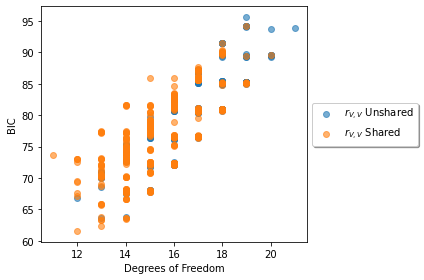

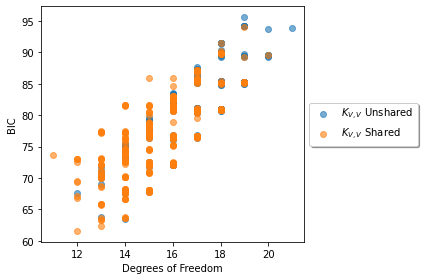

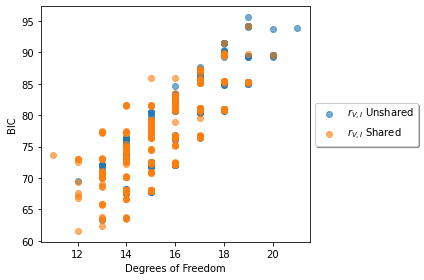

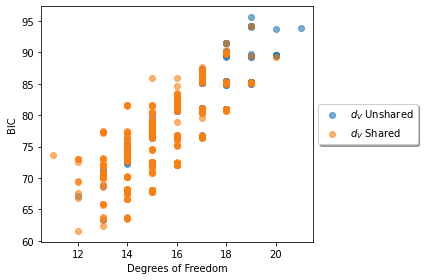

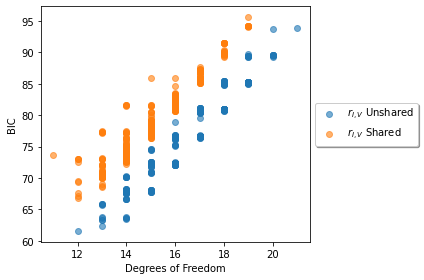

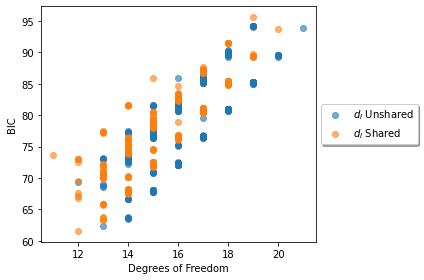

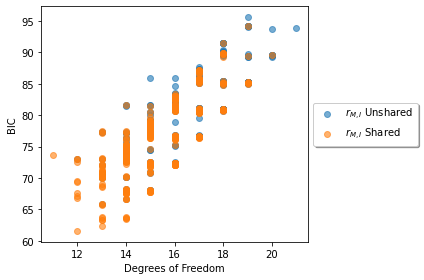

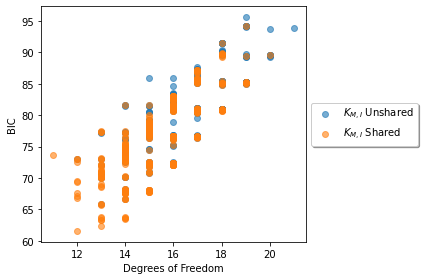

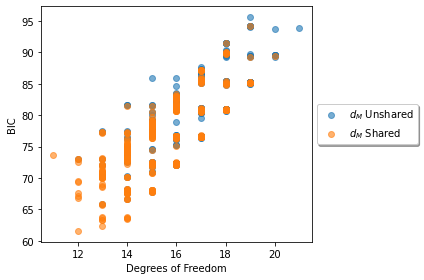

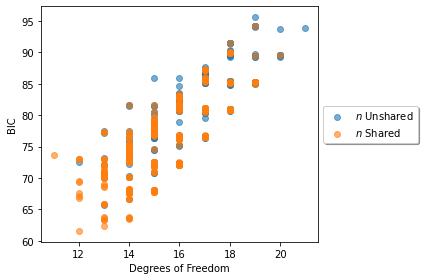

In [4]:
filename = 'Model_4'
plotTrends = False #Whether to plot the decomposed trendlines for each parameter
parCount = 10 #How many parameters are in the model
POI = list(range(0,parCount)) #Should any paramters be isolated? None to plot without any parameter seperation
column = range(0,parCount) #Which columns contain parameters?
maxBIC = 150 #Acceptable upper limit for a "converged" genome's BIC

#Parameter Labels
parLabel = ('$r_{V,V}$','$K_{V,V}$','$r_{V,I}$','$d_{V}$','$r_{I,V}$',
            '$d_{I}$','$r_{M,I}$','$K_{M,I}$','$d_{M}$','$n$')

#End user interactions, rest doesn't need input

#Load the raw data and look at the DOF:BIC "characteristic curve"
df = pd.read_csv('Data/Real Data/'+filename+'.csv', usecols=range(1,parCount+3))
df = dfSum(df, column)

df = df[(df['BIC'] < maxBIC)] #Remove unconverged genomes, if present. A few of these are expected, some genomes are unstable
df = df[(np.abs(stats.zscore(df['BIC'])) < 3)] #outlier removal
X = df[[str(x) for x in column]]
Y = df['BIC']

model = LinearRegression()
model.fit(X,Y)
scalar = math.log(78)
print('Intercept:',model.intercept_)
coeff_parameter = pd.DataFrame(model.coef_/scalar,X.columns,columns=['Coefficient'])
print(coeff_parameter)

if POI is not None:
    for i in range(0,len(column)):
        fig = plt.figure()
        ax1 = fig.add_subplot(111)  
        df1 = df.loc[df[str(column[i])] == 1]
        df0 = df.loc[df[str(column[i])] == 0]

        ax1.scatter(df1['DOF'],df1['BIC'],alpha=0.6,label=parLabel[i]+' Unshared')
        ax1.scatter(df0['DOF'],df0['BIC'],alpha=0.6, label=parLabel[i]+' Shared')
        
        ax1.set_ylabel('BIC')
        ax1.set_xlabel('Degrees of Freedom')

        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True, shadow=True)

        plt.tight_layout()
        
        fname = filename + '_' + str(parLabel[i])
        plt.savefig(fname + ' DOF-BIC Curve.png')
        plt.savefig(fname + ' DOF-BIC Curve.svg')

        plt.show()

        if plotTrends:
            xTrend, yTrend = plotLine(coeff_parameter['Coefficient'][column[i]], model.intercept_, np.min(df['DOF']), np.max(df['DOF']))
            ax1.plot(xTrend, yTrend, label=parLabel[i])
else:
    fig = plt.figure()
    ax1 = fig.add_subplot(111)  
    ax1.scatter(df['DOF'],df['BIC'])

    if plotTrends:
        for i in column:
            xTrend, yTrend = plotLine(coeff_parameter['Coefficient'][i], model.intercept_, np.min(df['DOF']), np.max(df['DOF']))
            ax1.plot(xTrend, yTrend, label=parLabel[i])

    ax1.set_ylabel('BIC')
    ax1.set_xlabel('Degrees of Freedom')


    plt.tight_layout()

    fname = filename + '_combined'
    plt.savefig(fname+' DOF-BIC Curve.png')
    plt.savefig(fname+' DOF-BIC Curve.svg')

    plt.show()

In [5]:
#Function to return confidence intervals etc. from OLS
#Execution time typically <30ms
def robust_linear(X,Y):
    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    return(est2.summary())

robust_linear(X,Y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BIC   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     2572.
Date:                Mon, 13 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:36:05   Log-Likelihood:                -1618.2
No. Observations:                1023   AIC:                             3258.
Df Residuals:                    1012   BIC:                             3313.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.0398      0.123    521.053      0.000      63.799      64.281
0              3.5323      0.074     47.741      0.000       3.387       3.677
1              3.7161      0.074     50.225      0.000       3.571       3.861
2              3.8103      0.074     51.498      0.000       3.665       3.955
3              3.6212      0.074     48.942      0.000       3.476       3.766
4             -3.7617      0.074    -50.841      0.000      -3.907      -3.616
5              1.2114      0.074     16.372      0.000       1.066       1.357
6              4.3015      0.074     58.137      0.000       4.156       4.447
7              4.2756      0.074     57.788      0.000       4.130       4.421
8              4.2599      0.074     57.575      0.000       4.115       4.405
9              4.1834      0.074     56.542      0.000       4.038       4.329
==============================================================================
Omnibus:                      415.465   Durbin-Watson:                   1.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2765.553
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                      10.282   Cond. No.                         7.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

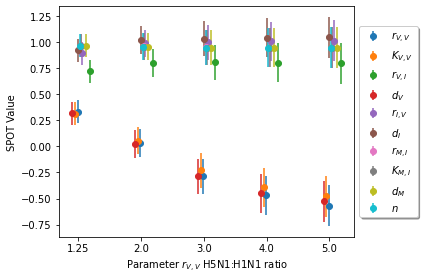

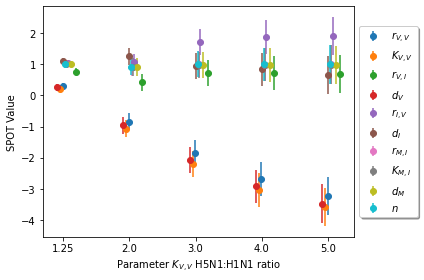

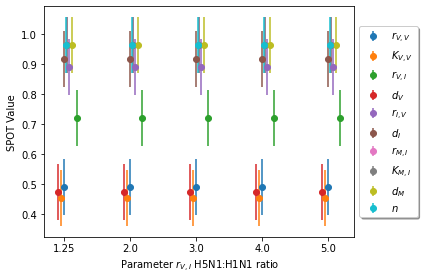

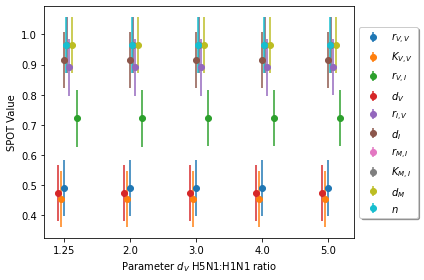

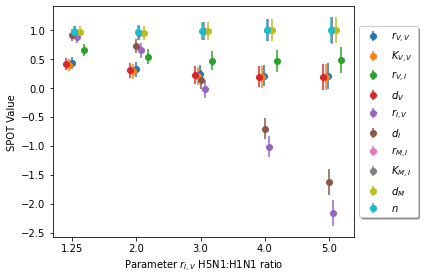

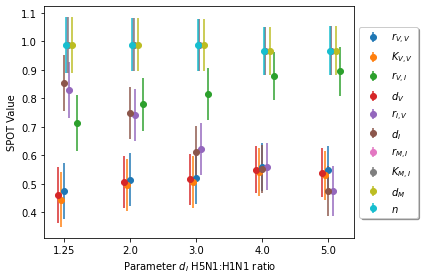

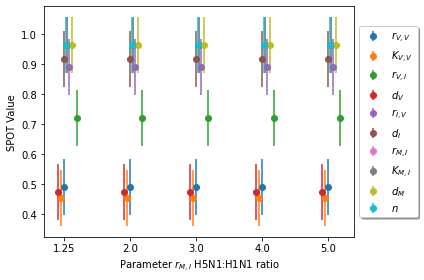

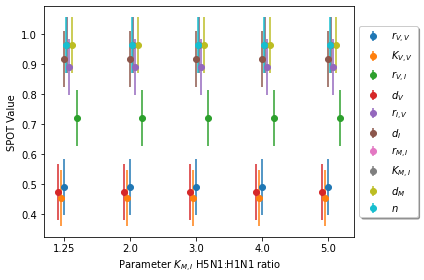

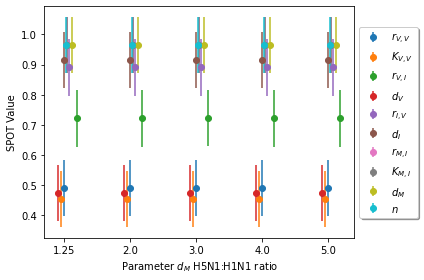

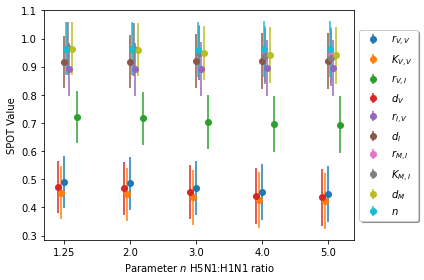

In [9]:
#Correlation coefficient vs paramater ratio
model = LinearRegression()
scalar = math.log(78)
p_count = 10 #Parameter count
x = (1.25, 2.0, 3.0, 4.0, 5.0) #Multiplier levels for parameters
x_index = list(range(0,len(x)))
spot = []
spotconf = []
method = 'ind' #Valid methods: 'ind' plots all parameters, 'grp' combines only varied parameters into one plot
    
def rand_jitter(arr):
    stdev = .1
    return arr + np.repeat(np.random.randn(1),len(arr)) * stdev
    
xvec = [rand_jitter(x) for x in np.vstack([x_index]*p_count)]

for j in range(0,p_count): #iterate over all parameters
    coeff_parameter = np.zeros((p_count,len(x)))
    conf_parameter = np.zeros((p_count,len(x)))
    for i in range(0,np.shape(x)[0]):
        df = pd.read_csv(('Data/Synthetic Data/Parameter Ratio Sweeps/Model 4/' + 
                          str(j)+' x '+str(x[i])+'.csv'), usecols=range(1,p_count+2))
        df = df[(np.abs(stats.zscore(df['BIC'])) < 3)] #outlier removal
        X = df[[str(x) for x in range(0,p_count)]]
        Y = df['BIC']
        X2 = sm.add_constant(X)
        est = sm.OLS(Y, X2)
        est2 = est.fit()
        conf = est2.conf_int()
        coeff_parameter[:,i] = (est2.params[1:]/scalar)
        conf_parameter[:,i] = (conf[1][1:]-est2.params[1:])/scalar

    row = ('$r_{V,V}$','$K_{V,V}$','$r_{V,I}$','$d_{V}$','$r_{I,V}$','$d_{I}$','$r_{M,I}$','$K_{M,I}$','$d_{M}$','$n$','$r_{V,M}$','$r_{I,M}$')

    #plotting regression coeff vs parameter ratio
    fig = plt.figure()
    ax1 = fig.add_subplot(111)    

    if method=='grp':
        ax1.errorbar(xvec[j], coeff_parameter[j], conf_parameter[j], fmt="o", label=row[j])
        spot.append(coeff_parameter[j])
        spotconf.append(conf_parameter[j])
    elif method=='ind':
        for i in range(0,p_count):
            ax1.errorbar(xvec[i], coeff_parameter[i], conf_parameter[i], fmt="o", label=row[i])

    ticks = list(range(0,5))
    ax1.xaxis.set_ticks(ticks)

    #ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    ax1.set_xticklabels([str(y) for y in x])
    ax1.set_ylabel('SPOT Value')
    
    z = (method+' parameter '+str(j)+' ratio analysis')
    
    ax1.set_xlabel('Parameter ' + row[j] + ' H5N1:H1N1 ratio')
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.savefig(z+'.png')
    plt.savefig(z+'.svg')
    plt.show()

In [72]:
#Slope of SPOT?

In [13]:
#Downsampling bootstrap 

df = pd.read_csv('Data/Real Data/Model_4.csv', usecols=range(1,13))
df = df[(np.abs(stats.zscore(df['BIC'])) < 3)] #outlier removal
x = np.flip(np.arange(1,0,-0.01))

samples = 100
params = np.zeros((11,x.size,samples))
conflow = np.zeros((11,x.size,samples))
confhigh = np.zeros((11,x.size,samples))
pval = np.zeros((10,x.size,samples))

for h in range(0,samples):
    for i in range(1,x.size):
        df_swap = df.sample(frac=x[i])
        X = df_swap[['0','1','2','3','4','5','6','7','8','9']]
        Y = df_swap['BIC']
        for j in range(0,10):
            idex = str(j)
            df1, df2 = [x for _, x in df_swap.groupby(df_swap[idex] == 1)]
            res=stats.ttest_ind(df1['BIC'], df2['BIC'])
            pval[j,i,h] = res.pvalue
        X2 = sm.add_constant(X)
        est = sm.OLS(Y, X2)
        est2 = est.fit()
        params[:,i,h] = est2.params
        conf = est2.conf_int()
        conflow[:,i,h] = conf[0]
        confhigh[:,i,h] = conf[1]
    params_avg = np.mean(params, axis=2)/scalar
    conflow_avg = np.mean(conflow, axis=2)/scalar
    confhigh_avg = np.mean(confhigh, axis=2)/scalar
    pval_avg = np.mean(pval, axis=2)

/home/jjw102/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jjw102/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


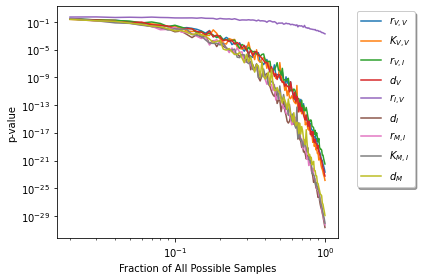

In [18]:
#Downsample p-value plotting
fig = plt.figure()
ax1 = fig.add_subplot(111)
row = ('$r_{V,V}$','$K_{V,V}$','$r_{V,I}$','$d_{V}$','$r_{I,V}$','$d_{I}$','$r_{M,I}$','$K_{M,I}$','$d_{M}$','$n$')

for i in range(1, 10):
    ax1.plot(x[1:], pval_avg[i,1:], label=row[i-1])
    
ax1.set_ylabel('p-value')
ax1.set_xlabel('Fraction of All Possible Samples')

ax1.set_xscale('log')
ax1.set_yscale('log')

#ax1.set_xlim(0.01,0.1)
#ax1.set_ylim(0.01,1.0)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',ncol=1, fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig('p value vs sample fraction zoom.png')
plt.savefig('p value vs sample fraction zoom.svg')
plt.show()

np.savetxt('pvalues.csv',pval_avg)

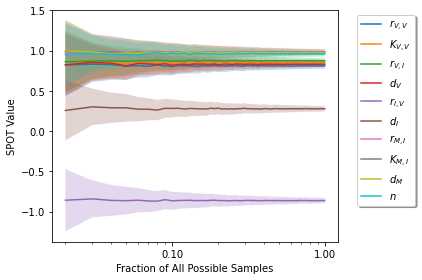

In [19]:
#Downsampling plotting, since bootstrapping takes lots of time
fig = plt.figure()
ax1 = fig.add_subplot(111)
row = ('$r_{V,V}$','$K_{V,V}$','$r_{V,I}$','$d_{V}$','$r_{I,V}$','$d_{I}$','$r_{M,I}$','$K_{M,I}$','$d_{M}$','$n$')

for i in range(1, 11):
    ax1.plot(x[1:], params_avg[i,1:], label=row[i-1])
    ax1.fill_between(x[1:], conflow_avg[i,1:], confhigh_avg[i,1:], alpha=0.25)
    
ax1.set_ylabel('SPOT Value')
ax1.set_xlabel('Fraction of All Possible Samples')

ax1.set_xscale('log')
from matplotlib.ticker import ScalarFormatter
for axis in [ax1.xaxis, ax1.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',ncol=1, fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig('SPOT Value vs Sample Fraction Model 4.svg')
plt.savefig('SPOT Value vs Sample Fraction Model 4.png')
plt.show()

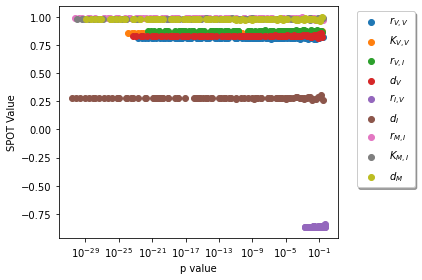

In [20]:
#SPOT value vs p-value
fig = plt.figure()
ax1 = fig.add_subplot(111)
row = ('$r_{V,V}$','$K_{V,V}$','$r_{V,I}$','$d_{V}$','$r_{I,V}$','$d_{I}$','$r_{M,I}$','$K_{M,I}$','$d_{M}$','$n$')

for i in range(1, 10):
    ax1.scatter(pval_avg[i,1:], params_avg[i,1:], label=row[i-1])
    
ax1.set_ylabel('SPOT Value')
ax1.set_xlabel('p value')

ax1.set_xscale('log')
#ax1.set_yscale('log')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',ncol=1, fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig('SPOT Value vs p-value Model 4.svg')
plt.show()

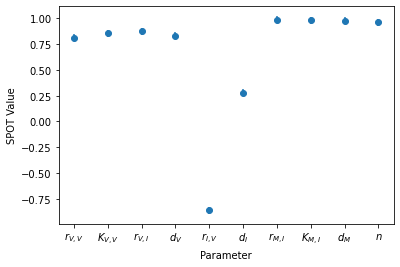

In [23]:
#Correlation coefficient for biological data

df = pd.read_csv('Data/Real Data/Model_4.csv', usecols=range(1,13))
df = df[(np.abs(stats.zscore(df['BIC'])) < 3)] #outlier removal
X = df[['0','1','2','3','4','5','6','7','8','9']]
Y = df['BIC']

scalar = math.log(78)

X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
params = est2.params[1:]
confraw = est2.conf_int()

conf = (confraw[1][1:]-params)/scalar
coeff_parameter = (params/scalar)

row = ('$r_{V,V}$','$K_{V,V}$','$r_{V,I}$','$d_{V}$','$r_{I,V}$','$d_{I}$','$r_{M,I}$','$K_{M,I}$','$d_{M}$','$n$')

pd.DataFrame(coeff_parameter, index=row)

fig = plt.figure()
ax1 = fig.add_subplot(111)
x = range(0,10,1)
ax1.errorbar(x, coeff_parameter, conf, fmt="o")
ax1.set_ylabel('SPOT Value')
ax1.set_xlabel('Parameter')
ax1.set_xticks(x)
ax1.set_xticklabels(row)
plt.savefig('Biological Result Model 4.png')
plt.savefig('Biological Result Model 4.svg')
plt.show()

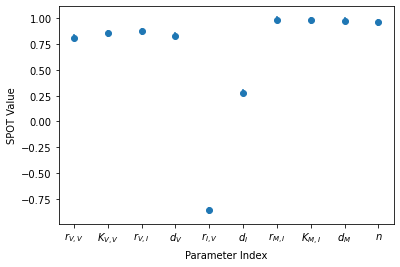

In [13]:
#Correlation coefficient for biological data, using parameter clusters
from functools import reduce
#Function to find dataframe rows where a column is one or zero
def rowsep(df, columns):
    #preallocate truth and heresy
    truth_indices = [[None]]*np.shape(columns)[0]
    heresy_indices = [[None]]*np.shape(columns)[0]
    
    #Because i.index doesn't work when i is a dataframe slice
    loop_counter = 0 
    
    #Iterate over all variables in the cluster
    for i in columns:
        
        #Get index list from dataframe
        index = df.index
        
        #Find rows with 1/0 in each Column
        truth_condition = df[i] == 1
        heresy_condition = df[i] == 0
        
        #Find where these occur
        truth_indices[loop_counter] = index[truth_condition].tolist()
        heresy_indices[loop_counter] = index[heresy_condition].tolist()
        
        loop_counter += 1
    
    #Find where all parameters in the cluster are matching case
    truth = reduce(np.intersect1d, (truth_indices))
    heresy = reduce(np.intersect1d, (heresy_indices))
    
    #Combine Truth and Heresy into a complete list of indices where the rows have matching values (all 1 or all 0)
    reclamation = np.concatenate((truth,heresy))
    return reclamation

df = pd.read_csv('Data/Real Data/Model_4.csv', usecols=range(1,13))
df = df[(np.abs(stats.zscore(df['BIC'])) < 3)] #outlier removal
scalar = math.log(78)

#Let's sample only where clusters of parameters are shared. 
#Step 1: Only rows where all parameters in the cluster have matching genome entries
cluster = ['0']#['0','1'] for r_v,v and K_v,v. Similar method to cluster any parameters.
cluster_loc = 0 #TODO find this location automatically
niave_index = ['0','1','2','3','4','5','6','7','8','9'] 
                   
if cluster is not None:
    df = df.iloc[rowsep(df,cluster)]

    #Step 2: Remove all but one column of the cluster, so SPOT will look at it as a single factor
    df = df.drop(cluster[1:],axis=1)

    #Step 3: run SPOT
    new_index = [item for item in niave_index if item not in cluster[1:]]

    X = df[new_index]
else:
    X = df[niave_index]
                   
Y = df['BIC']
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
params = est2.params[1:]
confraw = est2.conf_int()

conf = (confraw[1][1:]-params)/scalar
coeff_parameter = (params/scalar)
coeff_parameter[cluster_loc] -= (np.shape(cluster)[0]-1)
row = ('$r_{V,V}$','$K_{V,V}$','$r_{V,I}$','$d_{V}$','$r_{I,V}$','$d_{I}$','$r_{M,I}$','$K_{M,I}$','$d_{M}$','$n$')
#row = ('$r_{V,V}$ + $K_{V,V}$','$r_{V,I}$','$d_{V}$','$r_{I,V}$','$d_{I}$','$r_{M,I}$','$K_{M,I}$','$d_{M}$','$n$')
#row = ('$r_{V,V}$', '$K_{V,V}$','$r_{V,I}$','$d_{V}$','$r_{I,V}$','$d_{I}$','$r_{M,I}$+$K_{M,I}$+$n$','$d_{M}$')

fig = plt.figure()
ax1 = fig.add_subplot(111)
x = range(0,np.shape(new_index)[0],1)
ax1.errorbar(x, coeff_parameter, conf, fmt="o")
ax1.set_ylabel('SPOT Value')
ax1.set_xlabel('Parameter Index')
ax1.set_xticks(x)
ax1.set_xticklabels(row)
plt.savefig('Model 4 Biological Results.svg')
plt.savefig('Model 4 Biological Results.png')
plt.show()

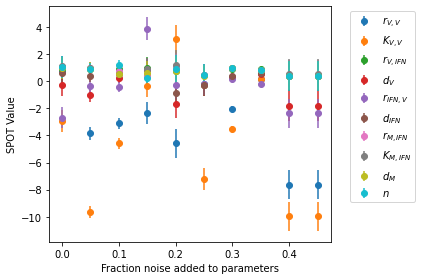

In [29]:
#Correlation coefficient vs biological noise
noise = np.arange(0, 0.50, 0.05)
p_count = 10 #parameters
coeff_noise=np.zeros((p_count,noise.size))
conf_noise = np.zeros((p_count,noise.size))

for i in range(0,len(noise)):
    target = 'Noisy_Parameters_10_samples_'+str(round(noise[i],4))+'.csv'
    df = pd.read_csv(target, usecols=range(1,p_count+3))
    df = df.loc[df['BIC'] < 500]
    df = df[(np.abs(stats.zscore(df['BIC'])) < 3)] #outlier removal for models with Z score > 3
    X = df[[str(x) for x in range(0,p_count)]]
    Y = df['BIC']
    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    params = est2.params[1:]
    confraw = est2.conf_int()
    
    coeff_noise[:,i] = (params/scalar)
    conf_noise[:,i] = (confraw[1][1:]-params)/scalar

row = ('$r_{V,V}$','$K_{V,V}$','$r_{V,IFN}$','$d_{V}$','$r_{IFN,V}$','$d_{IFN}$','$r_{M,IFN}$','$K_{M,IFN}$','$d_{M}$','$n$')

#plotting corr coeff vs parameter ratio
fig = plt.figure()
ax1 = fig.add_subplot(111)
x = list(noise)
for i in range(0,p_count):
    ax1.errorbar(noise, coeff_noise[i,:], conf_noise[i,:], fmt="o", label=row[i])
ax1.set_ylabel('SPOT Value')
ax1.set_xlabel('Fraction noise added to parameters')
#ax1.set_ylim(-5,5)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
#plt.savefig('SPOT Value vs noise.png')
plt.show()